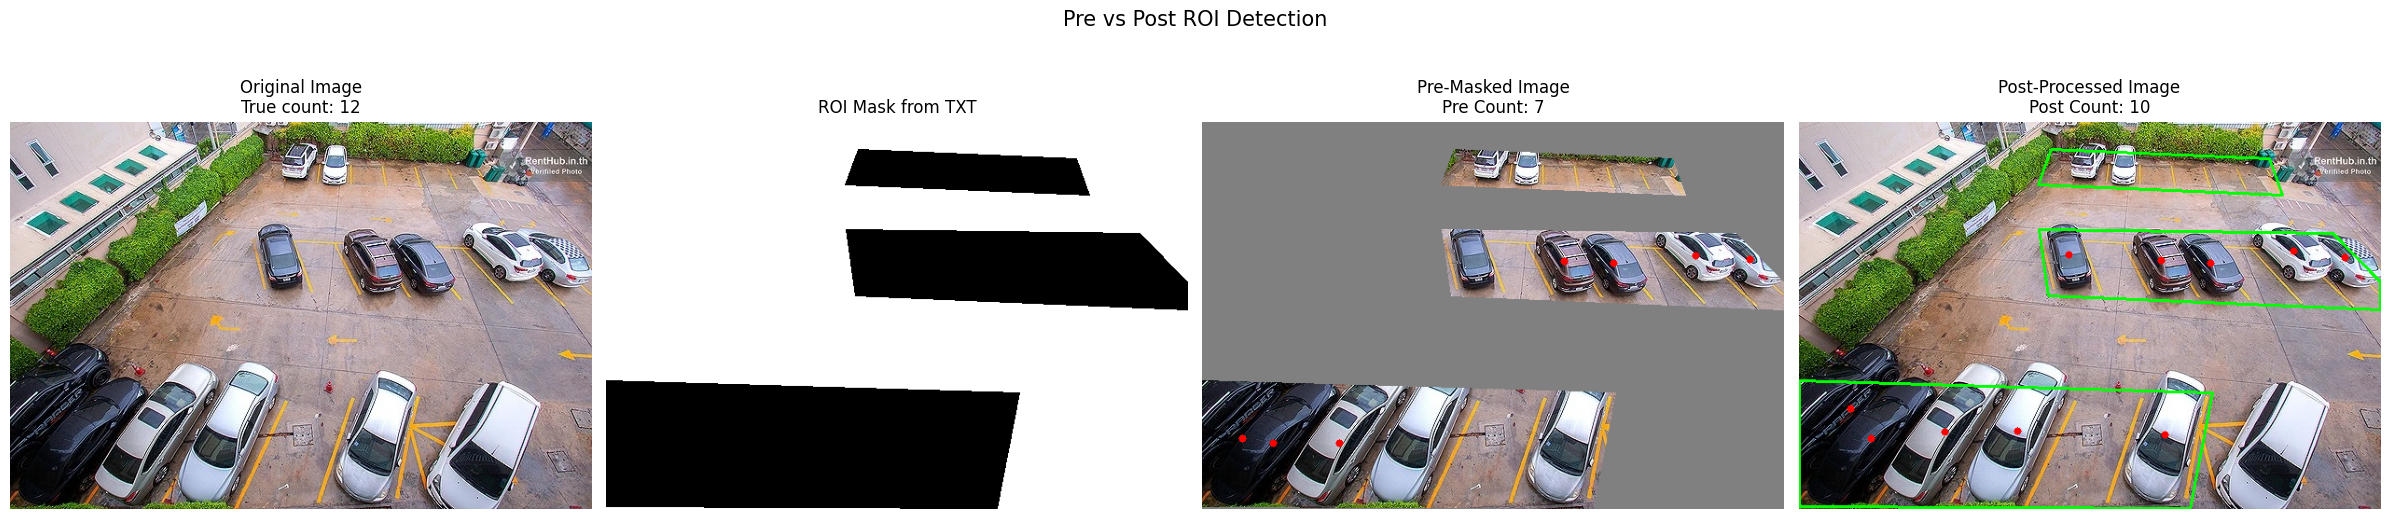

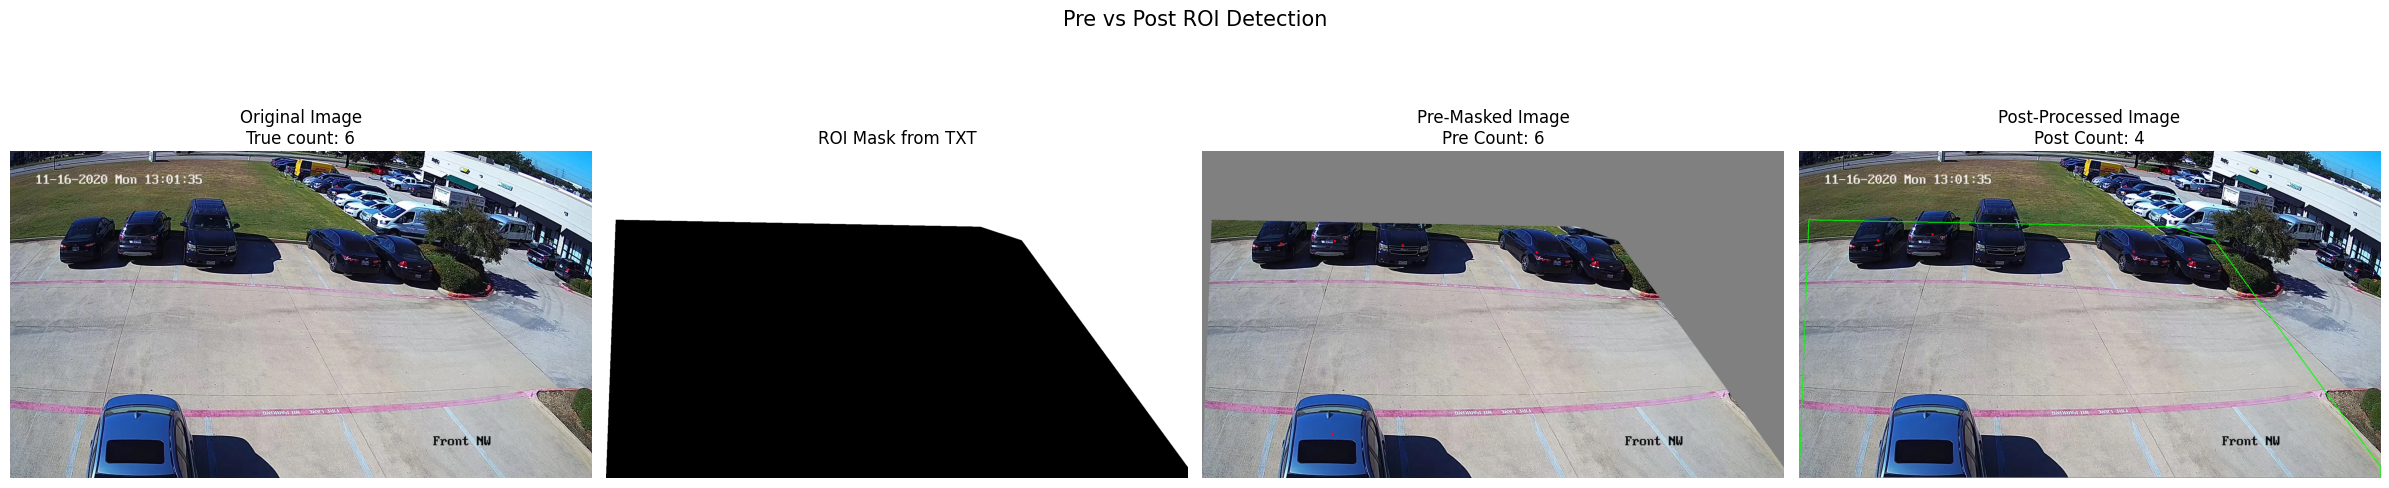

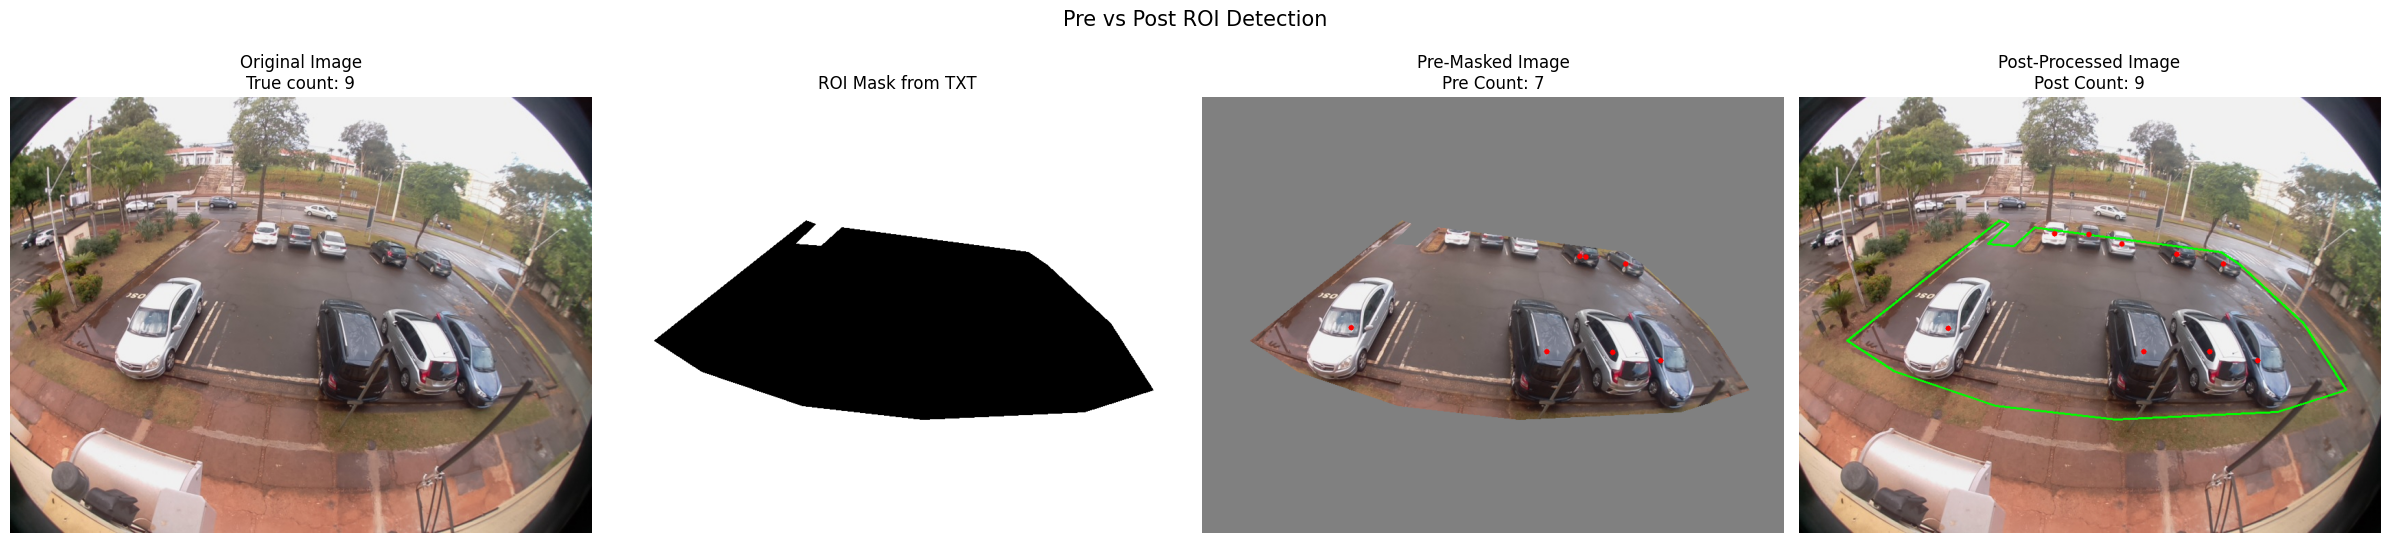

▶ TP: 20, FP: 0, FN: 7
▶ TP: 23, FP: 0, FN: 4

📌 Pre-processing 방식
  Accuracy: 74.07%, F1-score: 0.8511
📌 Post-processing 방식
  Accuracy: 85.19%, F1-score: 0.9200


In [3]:
import cv2
import numpy as np
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt

# -------- 설정 --------
IMAGE_PATHS = [f for f in os.listdir('.') if f.endswith('.jpg')]    # 예: test_3.jpg → 차량 수 3대
MODEL_PATH = 'yolov8n.pt'                                           # YOLO 모델 경로
TARGET_CLASS = 2                                                    # 차량 클래스 index (YOLO label에 따라 다름)
CONFIDENCE_THRESHOLD = 0.25                                         # confidence 필터 기준

# -------- 모델 로드 --------
model = YOLO(MODEL_PATH)

# -------- 중심점이 ROI 내부인지 확인 --------
def is_inside_roi(xy, mask):
    x, y = int(xy[0]), int(xy[1])
    if 0 <= y < mask.shape[0] and 0 <= x < mask.shape[1]:
        return mask[y, x] == 0
    return False

# -------- ROI 마스크 로딩 --------
def load_roi_mask_from_txt(txt_path, image_shape):
    h, w = image_shape[:2]
    mask = np.ones((h, w), dtype=np.uint8) * 255
    polygons = []
    if not os.path.exists(txt_path):
        print(f"[경고] {txt_path} 파일이 없습니다.")
        return mask, polygons
    with open(txt_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) < 7:
                continue
            coords = np.array([float(p) for p in parts[1:]]).reshape(-1, 2)
            coords[:, 0] *= w
            coords[:, 1] *= h
            polygon = np.int32([coords])
            cv2.fillPoly(mask, polygon, 0)
            polygons.append(polygon)
    return mask, polygons

# -------- Pre 방식 마스킹 --------
def apply_pre_mask(image, mask):
    masked = image.copy()
    gray = np.full_like(masked, 128)
    mask_3c = cv2.merge([mask, mask, mask])
    return np.where(mask_3c == 255, gray, masked)

# -------- Pre 방식 탐지 중심점 반환 --------
def count_and_centers_pre(results):
    count = 0
    centers = []
    for box in results.boxes:
        if int(box.cls[0]) != TARGET_CLASS:
            continue
        x1, y1, x2, y2 = box.xyxy[0]
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)
        count += 1
        centers.append((cx, cy))
    return count, centers

# -------- Post 방식 ROI 중심점 --------
def count_in_roi_post(results, mask):
    count = 0
    centers = []
    for box in results.boxes:
        if int(box.cls[0]) != TARGET_CLASS:
            continue
        x1, y1, x2, y2 = box.xyxy[0]
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)
        if is_inside_roi((cx, cy), mask):
            count += 1
            centers.append((cx, cy))
    return count, centers

# -------- 평가 함수 --------
def evaluate(pred_counts, true_counts):
    TP, FP, FN = 0, 0, 0
    for pred, true in zip(pred_counts, true_counts):
        TP += min(pred, true)
        FP += max(pred - true, 0)
        FN += max(true - pred, 0)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    total_true = sum(true_counts)
    acc = TP / total_true if total_true > 0 else 0.0
    print(f"▶ TP: {TP}, FP: {FP}, FN: {FN}")
    return acc, f1

# -------- 메인 루프 --------
y_true, y_pred_pre, y_pred_post = [], [], []

for img_path in IMAGE_PATHS:
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    txt_path = img_path.replace('.jpg', '.txt')
    mask, polygons = load_roi_mask_from_txt(txt_path, (h, w))
    true_count = int(img_path.split('_')[-1].split('.')[0])
    y_true.append(true_count)

    # --- Pre ---
    pre_img = apply_pre_mask(img, mask)
    result_pre = model(pre_img, verbose=False, conf=CONFIDENCE_THRESHOLD)[0]
    pre_count, pre_centers = count_and_centers_pre(result_pre)
    y_pred_pre.append(pre_count)

    # --- Post ---
    result_post = model(img, verbose=False, conf=CONFIDENCE_THRESHOLD)[0]
    post_count, post_centers = count_in_roi_post(result_post, mask)
    y_pred_post.append(post_count)

    # Pre 방식 시각화
    pre_vis = pre_img.copy()
    for cx, cy in pre_centers:
        cv2.circle(pre_vis, (cx, cy), 4, (0, 0, 255), -1)

    # Post 방식 시각화
    post_vis = img.copy()
    for poly in polygons:
        cv2.polylines(post_vis, poly, isClosed=True, color=(0, 255, 0), thickness=2)
    for cx, cy in post_centers:
        cv2.circle(post_vis, (cx, cy), 4, (0, 0, 255), -1)

    # -------- 시각화 --------
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))

    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f"Original Image\nTrue count: {true_count}")
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("ROI Mask from TXT")
    axs[1].axis('off')

    axs[2].imshow(cv2.cvtColor(pre_vis, cv2.COLOR_BGR2RGB))
    axs[2].set_title(f"Pre-Masked Image\nPre Count: {pre_count}")
    axs[2].axis('off')

    axs[3].imshow(cv2.cvtColor(post_vis, cv2.COLOR_BGR2RGB))
    axs[3].set_title(f"Post-Processed Image\nPost Count: {post_count}")
    axs[3].axis('off')

    plt.suptitle("Pre vs Post ROI Detection", fontsize=15)
    plt.tight_layout()
    plt.show()

# -------- 결과 출력 --------
acc_pre, f1_pre = evaluate(y_pred_pre, y_true)
acc_post, f1_post = evaluate(y_pred_post, y_true)

print("\n📌 Pre-processing 방식")
print(f"  Accuracy: {acc_pre*100:.2f}%, F1-score: {f1_pre:.4f}")
print("📌 Post-processing 방식")
print(f"  Accuracy: {acc_post*100:.2f}%, F1-score: {f1_post:.4f}")